## Imports

In [1]:
%env CUDA_VISIBLE_DEVICES=1

env: CUDA_VISIBLE_DEVICES=1


In [2]:
import torch
import matplotlib.pyplot as plt

In [3]:
import matplotlib
matplotlib.rcParams['figure.facecolor'] = 'white'

In [4]:
DEVICE = torch.device('cuda')
DEVICE

device(type='cuda')

In [5]:
%run ../utils/__init__.py

## Load data

In [6]:
%run ../datasets/__init__.py

### Load seg dataset

In [27]:
kwargs = {
    'dataset_name': 'jsrt',
    'dataset_type': 'test',
    'norm_by_sample': True,
    'image_size': (1024, 1024),
}
jsrt_dataloader = prepare_data_segmentation(**kwargs)
len(jsrt_dataloader.dataset)

62

In [28]:
jsrt_dataloader.dataset.__class__.__name__

'JSRTDataset'

In [8]:
item = jsrt_dataloader.dataset[1]
item.image.size()

torch.Size([1, 1024, 1024])

(-0.5, 1023.5, 1023.5, -0.5)

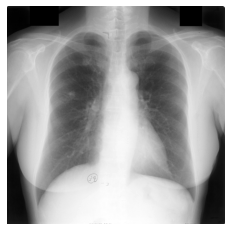

In [9]:
plt.imshow(item.image[0], cmap='gray')
plt.axis('off')

### Load IU x-ray

In [7]:
kwargs = {
    'dataset_name': 'iu-x-ray',
    'dataset_type': 'train',
    'batch_size': 10,
    'image_format': 'L',
    'frontal_only': True,
    'norm_by_sample': True,
    'image_size': (1024, 1024),
}

iu_dataloader = prepare_data_classification(**kwargs)
len(iu_dataloader.dataset)

3031

In [8]:
item = iu_dataloader.dataset[1]
item.image.size()

torch.Size([1, 1024, 1024])

(-0.5, 1023.5, 1023.5, -0.5)

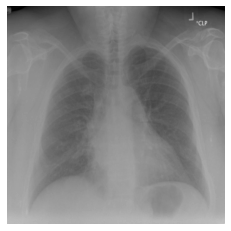

In [9]:
plt.imshow(item.image[0], cmap='gray')
plt.axis('off')

### Load CXR-14

In [11]:
kwargs = {
    'dataset_name': 'cxr14',
    'dataset_type': 'train',
    'batch_size': 10,
    'image_format': 'L',
    'norm_by_sample': True,
    'image_size': (1024, 1024),
}

cxr14_dataloader = prepare_data_classification(**kwargs)
len(cxr14_dataloader.dataset)

75714

### Covid-UC

In [41]:
kwargs = {
    'dataset_name': 'covid-uc',
    'dataset_type': 'train',
    'batch_size': 10,
    'image_format': 'L',
    'frontal_only': True,
    'norm_by_sample': True,
    'image_size': (1024, 1024),
}

coviduc_dataloader = prepare_data_classification(**kwargs)
len(coviduc_dataloader.dataset)

Loading covid-uc/train dataset...


551

## Load model

In [12]:
%run ../models/checkpoint/__init__.py

In [13]:
# run_name = '1105_180035_jsrt_scan_lr0.0001_normD_size1024'
# run_name = '1106_092037_jsrt_scan_lr0.0001_normD_size1024'
# run_name = '1106_180455_jsrt_scan_lr0.0005_normS_size1024_wce1-4-3-3_sch-iou-p5-f0.2'
run_name = '1202_015907_jsrt_scan_lr0.0005_normS_size1024_wce1-6-3-3_aug10_sch-iou-p5-f0.5'
debug = False

# run_name = '1106_165046_jsrt_scan_lr0.0001_normS_size1024_wce1-4-3-3'
# run_name = '1106_174749_jsrt_scan_lr0.0001_normS_size1024_wce1-4-3-3'
# run_name = '1106_175002_jsrt_scan_lr0.0001_normS_size1024_wce1-4-3-3'
# debug = True

In [14]:
compiled_model = load_compiled_model_segmentation(run_name, debug=debug, device=DEVICE)
compiled_model.metadata

{'model_kwargs': {'model_name': 'scan', 'n_classes': 4},
 'opt_kwargs': {'lr': 0.0005},
 'lr_sch_kwargs': {'mode': 'max',
  'threshold_mode': 'abs',
  'factor': 0.5,
  'patience': 5,
  'verbose': True},
 'hparams': {'loss_weights': [0.1, 0.6, 0.3, 0.3],
  'early_stopping': True,
  'early_stopping_kwargs': {'patience': 20, 'metric': 'iou', 'min_delta': 0},
  'lr_sch_metric': 'iou'},
 'dataset_kwargs': {'dataset_name': 'jsrt',
  'batch_size': 20,
  'image_size': [1024, 1024],
  'num_workers': 2,
  'norm_by_sample': True},
 'dataset_train_kwargs': {'shuffle': None,
  'augment': True,
  'augment_label': None,
  'augment_class': None,
  'augment_times': 10,
  'augment_kwargs': {'crop': 0.8,
   'translate': 0.1,
   'rotation': 15,
   'contrast': 0.8,
   'brightness': 0.8,
   'shear': [10, 10]}}}

## Examples

### Functions

In [15]:
%run ../utils/nlp.py

In [16]:
def calculate_output(item):
    images = item.image.unsqueeze(0).to(DEVICE)

    with torch.no_grad():
        outputs = compiled_model.model(images)

    outputs = outputs.squeeze(0)
    _, outputs = outputs.max(dim=0)
    outputs = outputs.detach().cpu().numpy() # height, width
    
    return outputs

In [17]:
def print_report(dataloader, idx):
    dataset = dataloader.dataset
    item = dataset[idx]
    
    report_reader = ReportReader(dataset.get_vocab())
    
    report = report_reader.idx_to_text(item.report)
    
    print(report)

In [29]:
def plot_example(dataloader, idx, titlesize=15):
    dataset = dataloader.dataset
    item = dataset[idx]
    outputs = calculate_output(item)
    
    plt.figure(figsize=(15, 10))
    plt.subplot(1, 2, 1)
    title = f'Image from {dataset.__class__.__name__}'
    if dataset.__class__.__name__ == 'JSRTDataset':
        title += f', {dataset.dataset_type}'
    plt.title(title, fontsize=titlesize)
    plt.imshow(item.image[0], cmap='gray')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.title('Segmentation map', fontsize=titlesize)
    plt.imshow(outputs)
    plt.axis('off')

### JSRT examples

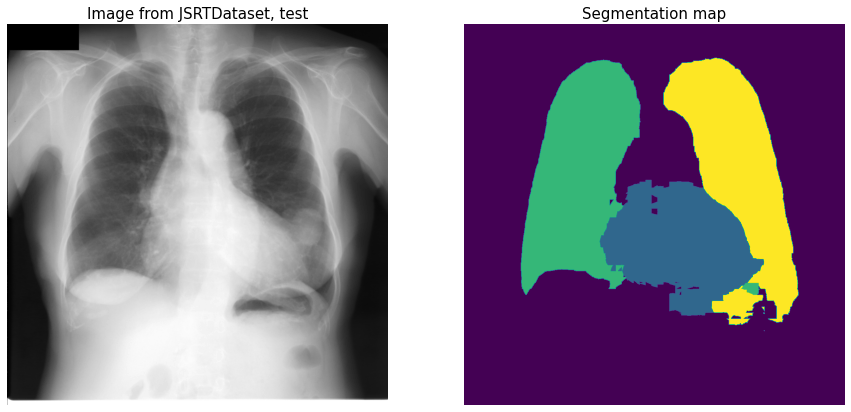

In [23]:
plot_example(jsrt_dataloader, 0)

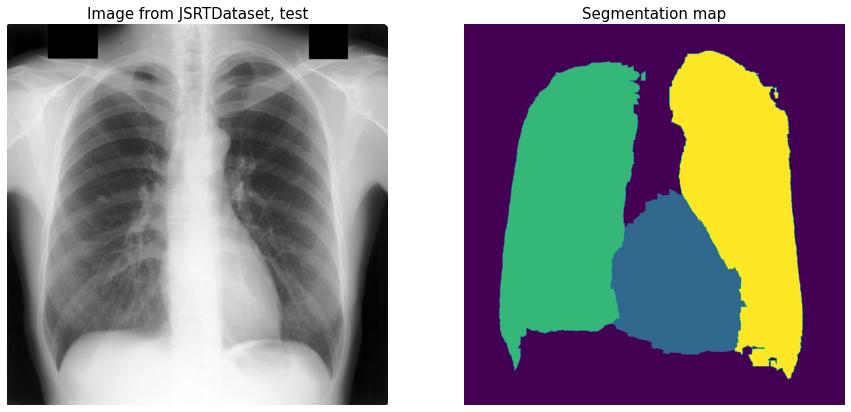

In [24]:
plot_example(jsrt_dataloader, 3)

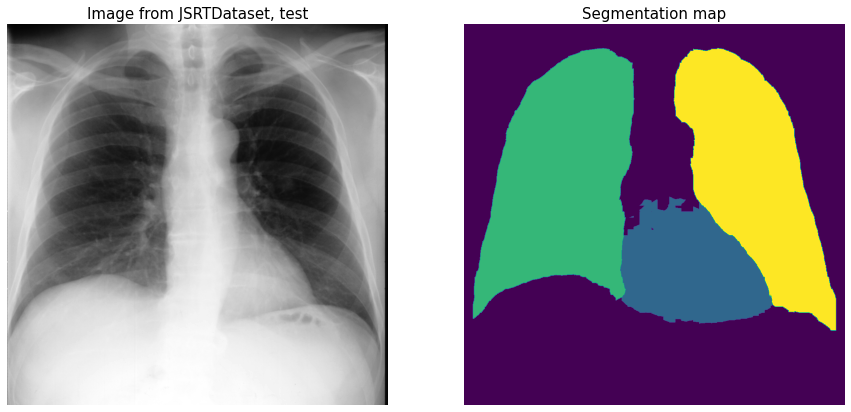

In [25]:
plot_example(jsrt_dataloader, 20)

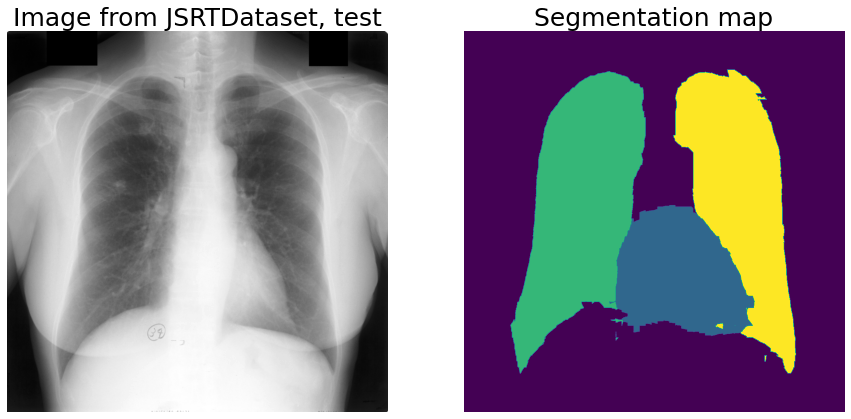

In [26]:
plot_example(jsrt_dataloader, 1, titlesize=25)

### IU x-ray dataset

no active disease .


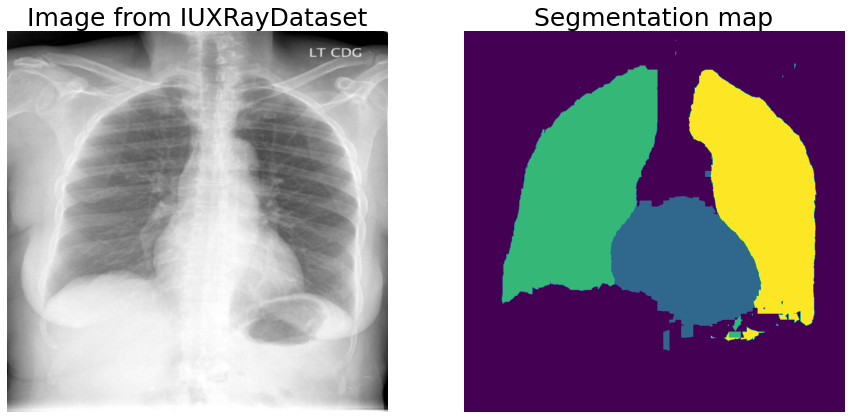

In [30]:
idx = 2
print_report(iu_dataloader, idx)
plot_example(iu_dataloader, idx, titlesize=25)

the cardiac contours are normal . the lungs are clear . thoracic spondylosis . mild dextrocurvature the spine .


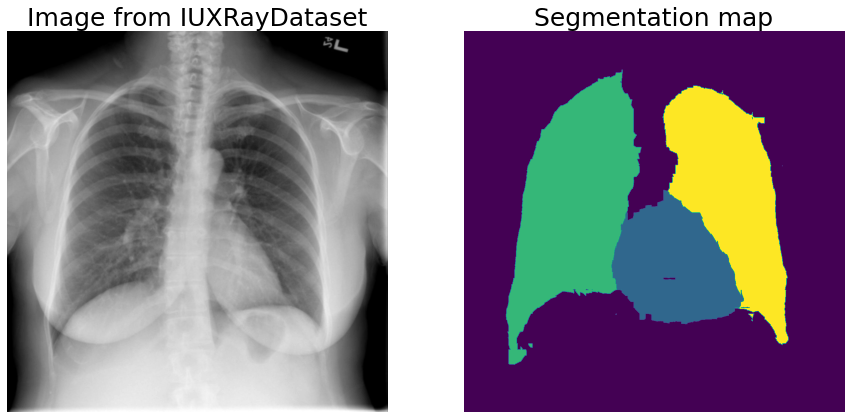

In [31]:
idx = 300
print_report(iu_dataloader, idx)
plot_example(iu_dataloader, idx, titlesize=25)

the heart size and pulmonary vascularity appear within normal limits . left xxxx-a-xxxx is in xxxx . no pleural effusion or pneumothorax is seen . right upper lobe area of dense opacity is seen in the medial right apex . on a previous outside xxxx scan ( xxxx ) , the right upper lobe was consolidated . comparison to the xxxx xxxx from that exam shows this opacity to have decreased . no films were available , however , for direct comparison .


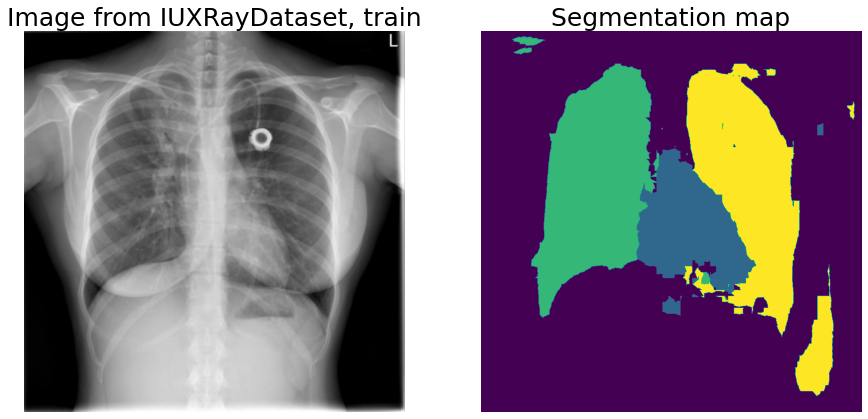

In [22]:
idx = -50
print_report(iu_dataloader, idx)
plot_example(iu_dataloader, idx, titlesize=25)

cardiomediastinal silhouette and pulmonary vasculature are within normal limits . lungs are clear . no pneumothorax or pleural effusion . no acute osseous findings .


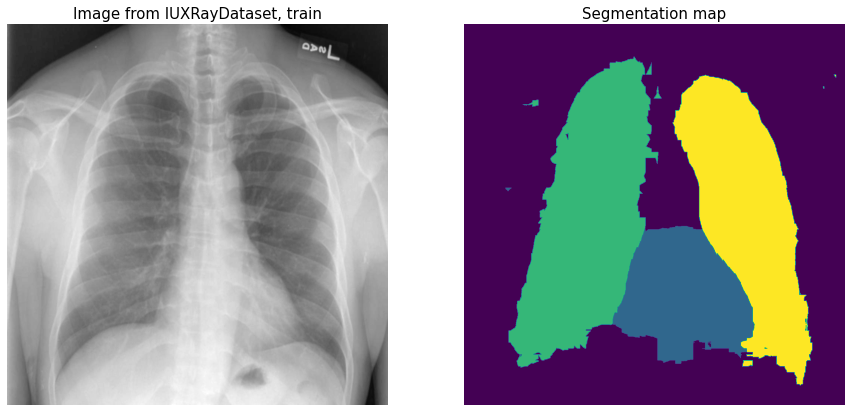

In [23]:
idx = 740
print_report(iu_dataloader, idx)
plot_example(iu_dataloader, idx)

### CXR-14 examples

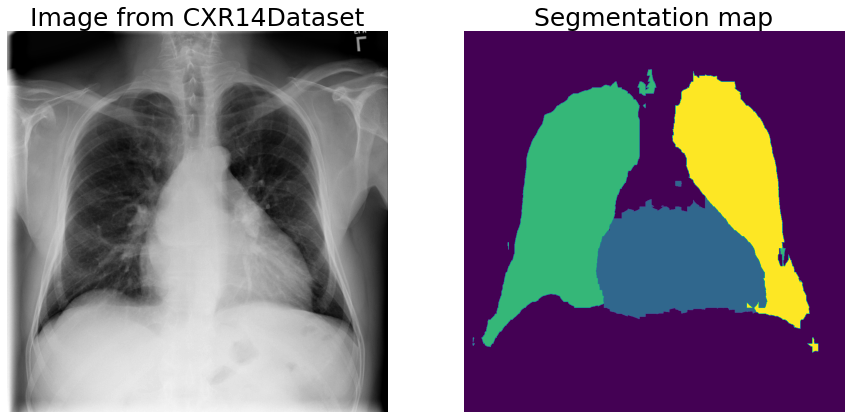

In [32]:
plot_example(cxr14_dataloader, 0, titlesize=25)

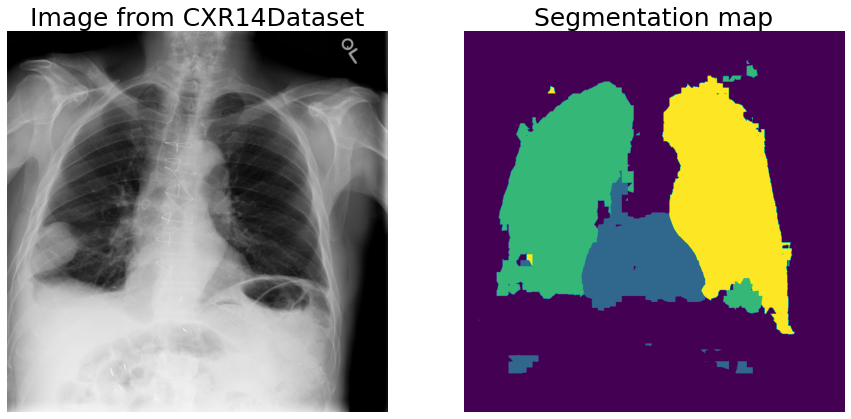

In [33]:
plot_example(cxr14_dataloader, 20, titlesize=25)

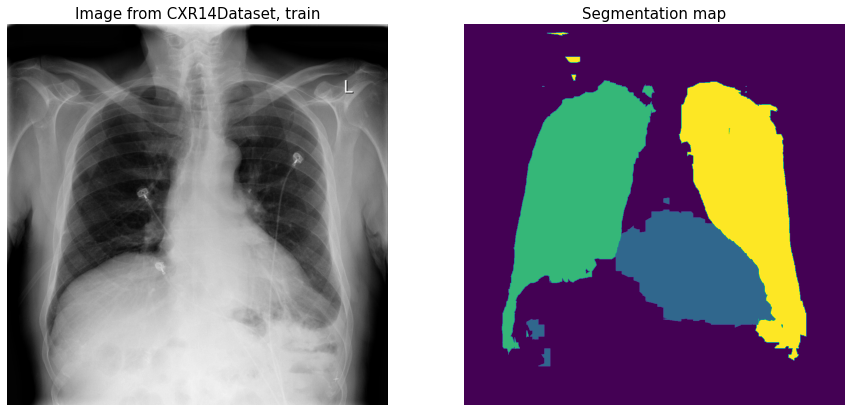

In [40]:
plot_example(cxr14_dataloader, 50)

### Covid-UC

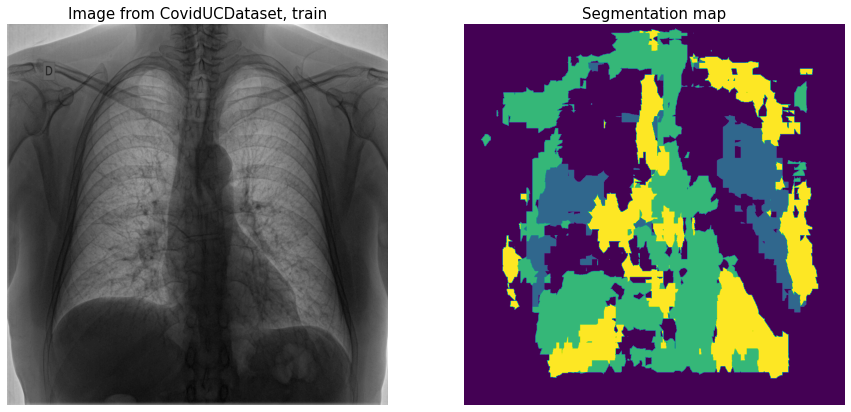

In [54]:
plot_example(coviduc_dataloader, 2)

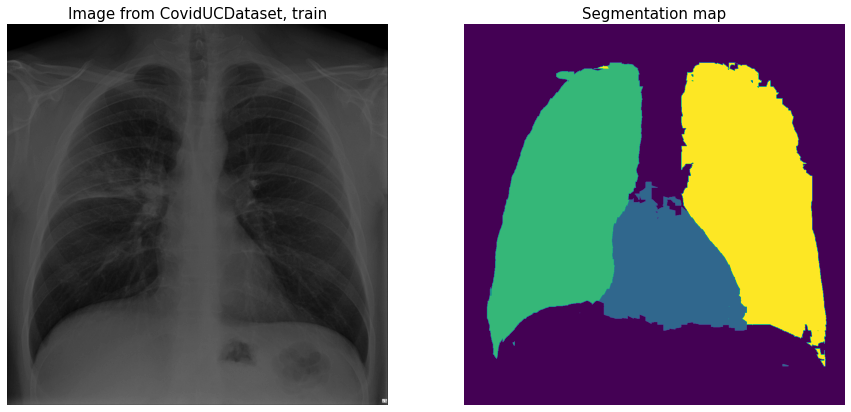

In [43]:
plot_example(coviduc_dataloader, 15)

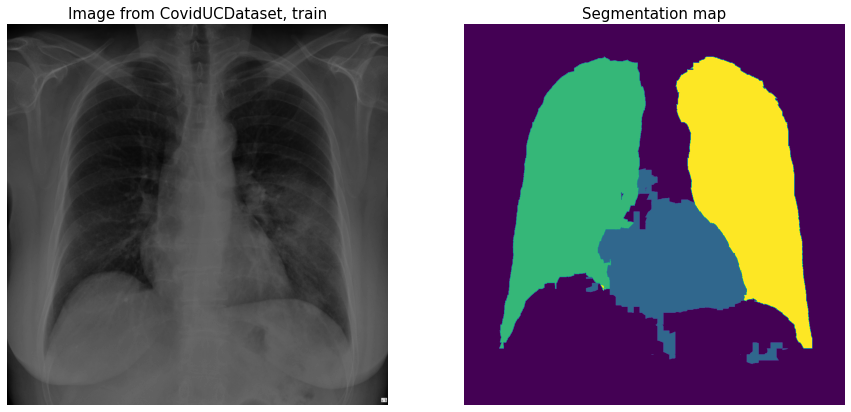

In [44]:
plot_example(coviduc_dataloader, 6)

In [35]:
coviduc_dataloader.dataset._metadata_df.iloc[1]

ID                                                 17
Fecha consulta SU                          2020-03-02
Resultado consenso BSTI                     Non-COVID
date                                       2020-03-02
image_name                 17-0-IM-0001-0001-0001.png
view                                               PA
Name: 1, dtype: object